In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import holidays

In [2]:
#df_cons = pd.read_excel('datasets/Actual_consumption_202001010000_202011242359.xlsx', skiprows=6,na_values='-')
#df_price = pd.read_excel('datasets/Day-ahead_prices_202001010000_202011242359.xlsx', skiprows=6, na_values='-')
#df_gen = pd.read_excel('datasets/Actual_generation_202001010000_202011242359.xlsx', skiprows=6, na_values='-')

df_cons = pd.read_excel('datasets/Actual_consumption_201901010000_202011302359.xlsx', skiprows=6,na_values='-')
df_price = pd.read_excel('datasets/Day-ahead_prices_201901010000_202011302359.xlsx', skiprows=6, na_values='-')
df_gen = pd.read_excel('datasets/Actual_generation_201901010000_202011302359.xlsx', skiprows=6, na_values='-')

#Concatenate Date + Time and create TimeSeries
df_cons['Date'] = pd.to_datetime(df_cons['Date'] + ' ' + df_cons['Time of day'])
#Create Timeseries index for 
df_cons['Date'] = df_cons['Date'].dt.tz_localize('Europe/Berlin', ambiguous='infer')
#Drop Unused column
df_cons.drop('Time of day', axis=1, inplace=True)
#Create Timeseries index for
df_cons.set_index('Date', inplace=True)
#Convert to GWh for better Visualization
df_cons['Total[MWh]']/=1000
df_cons.rename(columns={'Total[MWh]': 'TotalConsumption[GWh]'}, inplace=True)

#Repeat the same steps for Prices Dataset
df_price['Date'] = pd.to_datetime(df_price['Date'] + ' ' + df_price['Time of day'])
df_price['Date'] = df_price['Date'].dt.tz_localize('Europe/Berlin', ambiguous='infer')
df_price.set_index('Date', inplace=True)
df_price.drop(df_price.columns[[0,2,3,4,5,6,7,8,9,10,11,12,13,14]], axis=1, inplace=True)
#Remove Market Signals
df_price['Germany/Luxembourg[€/MWh]'] = df_price[df_price['Germany/Luxembourg[€/MWh]'] > 1]

#Repeat the same steps for Power Generation Dataset 
df_gen['Date'] = pd.to_datetime(df_gen['Date'] + ' ' + df_gen['Time of day'])
df_gen['Date'] = df_gen['Date'].dt.tz_localize('Europe/Berlin', ambiguous='infer')
df_gen.drop('Time of day', axis=1, inplace=True)
df_gen.set_index('Date', inplace=True)
6
#Create the Total Power Generation Column also known as Sypply
df_gen['TotalGeneration[MWh]'] = (df_gen['Biomass[MWh]'] + 
        df_gen['Hydropower[MWh]']+
        df_gen['Wind offshore[MWh]'] +
        df_gen['Wind onshore[MWh]']+
        df_gen['Photovoltaics[MWh]']+
        df_gen['Other renewable[MWh]']+ 
        df_gen['Nuclear[MWh]']+ 
        df_gen['Fossil brown coal[MWh]']+
        df_gen['Fossil hard coal[MWh]']+ 
        df_gen['Fossil gas[MWh]']+ 
        df_gen['Hydro pumped storage[MWh]']+
        df_gen['Other conventional[MWh]'])

#Convert all columns to GWh
df_gen['TotalGeneration[MWh]']/=1000  
df_gen['Biomass[MWh]']/=1000
df_gen['Hydropower[MWh]']/=1000
df_gen['Wind offshore[MWh]']/=1000
df_gen['Wind onshore[MWh]']/=1000
df_gen['Photovoltaics[MWh]']/=1000
df_gen['Other renewable[MWh]']/=1000
df_gen['Nuclear[MWh]']/=1000
df_gen['Fossil brown coal[MWh]']/=1000
df_gen['Fossil hard coal[MWh]']/=1000
df_gen['Fossil gas[MWh]']/=1000
df_gen['Hydro pumped storage[MWh]']/=1000
df_gen['Other conventional[MWh]']/=1000

df_gen.rename(columns={'TotalGeneration[MWh]': 'TotalGeneration[GWh]',
                       'Biomass[MWh]':'Biomass[GWh]',
                       'Hydropower[MWh]': 'Hydropower[GWh]',
                       'Wind offshore[MWh]': 'Wind offshore[GWh]',
                       'Wind onshore[MWh]':'Wind onshore[GWh]',
                       'Photovoltaics[MWh]':'Photovoltaics[GWh]',
                       'Other renewable[MWh]':'Other renewable[GWh]',
                       'Nuclear[MWh]':'Nuclear[GWh]',
                       'Fossil brown coal[MWh]':'Fossil brown coal[GWh]',
                       'Fossil hard coal[MWh]':'Fossil hard coal[GWh]',
                       'Fossil gas[MWh]':'Fossil gas[GWh]',
                       'Hydro pumped storage[MWh]':'Hydro pumped storage[GWh]',
                       'Other conventional[MWh]':'Other conventional[GWh]'                      
                      }, inplace=True)


#Downsample datasets to a daily frequency 
df_dcons = df_cons.resample('D').sum()
df_dgen = df_gen.resample('D').sum()
df_dprice = df_price.resample('D').median()

#Merge Datasets into a single one
df = pd.merge(df_dcons, df_dgen, left_index=True, right_index=True )
df = pd.merge(df, df_dprice, left_index=True, right_index=True )

#Calculate Non-base Demand According to the chosen paper
df['Non-base Demand[GWh]'] = df['TotalConsumption[GWh]'] - df['Hydropower[GWh]'] - df['Nuclear[GWh]']
#Calculate Supply-Demand Index
df['SupplyDemandIndex[SDI]'] = (df['TotalGeneration[GWh]'] - df['TotalConsumption[GWh]'])/ df['TotalConsumption[GWh]']*100

#Get weekday
df['DoW'] = df.index.dayofweek

#Get holidays in Germany
de_holidays = holidays.DEU()
df['Weekend/Holiday'] = df.apply(lambda x: x.name in de_holidays or x.DoW in [5,6], axis=1)

#Window of 90 Days
window = 90

#remove rolls without prices
df = df[~df['Germany/Luxembourg[€/MWh]'].isnull()]
df['PriceDeviation'] = df['Germany/Luxembourg[€/MWh]'].rolling(window).std(win_type='gaussian')
#For displaying purpose
df['Non-base Demand[10GWh]'] = df['Non-base Demand[GWh]'] / 10

#Calculate Price Spike
df['PriceSpike'] =  df['Germany/Luxembourg[€/MWh]'] > df['Germany/Luxembourg[€/MWh]'].rolling(window).mean() + df['PriceDeviation'] * 2

<AxesSubplot:xlabel='Date'>

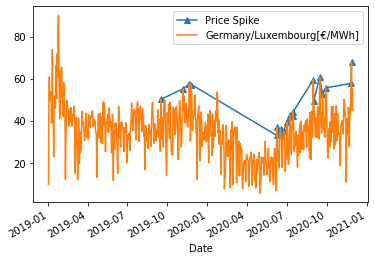

In [3]:
df[df['PriceSpike']]['Germany/Luxembourg[€/MWh]'].plot(marker='^',label='Price Spike', legend=True)
df['Germany/Luxembourg[€/MWh]'].plot(legend=True)

<AxesSubplot:xlabel='Date'>

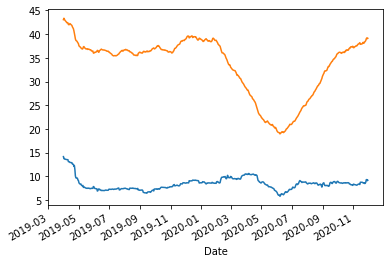

In [4]:
df['PriceDeviation'].plot()
df['Germany/Luxembourg[€/MWh]'].rolling(window).mean().plot()

<AxesSubplot:xlabel='Date'>

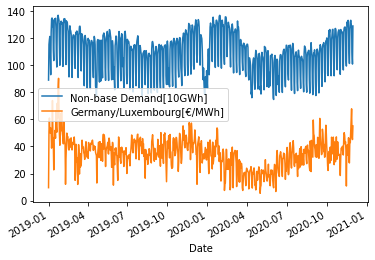

In [5]:
df[['Non-base Demand[10GWh]', 'Germany/Luxembourg[€/MWh]']].plot(legend=True)

<AxesSubplot:xlabel='Date'>

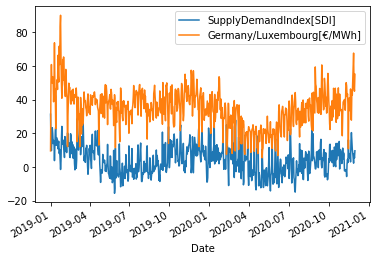

In [6]:
df[['SupplyDemandIndex[SDI]', 'Germany/Luxembourg[€/MWh]']].plot(legend=True)


In [7]:
#Skip Temperature and Capacity-Flow for simplicity

<AxesSubplot:xlabel='TotalConsumption[GWh]', ylabel='Germany/Luxembourg[€/MWh]'>

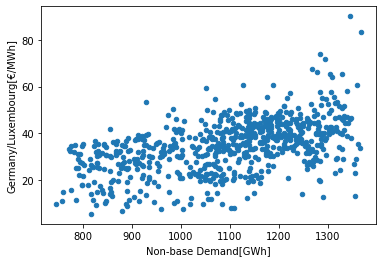

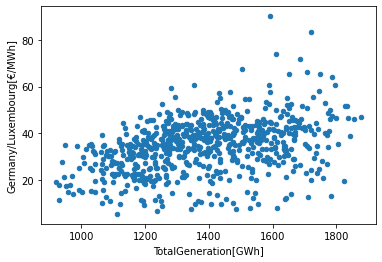

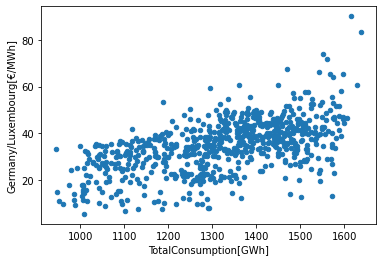

In [8]:
df.plot(kind='scatter', x='Non-base Demand[GWh]' ,y='Germany/Luxembourg[€/MWh]' )
df.plot(kind='scatter', x='TotalGeneration[GWh]' ,y='Germany/Luxembourg[€/MWh]' )
df.plot(kind='scatter', x='TotalConsumption[GWh]' ,y='Germany/Luxembourg[€/MWh]' )

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 699 entries, 2019-01-01 00:00:00+01:00 to 2020-11-30 00:00:00+01:00
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   TotalConsumption[GWh]      699 non-null    float64
 1   Residual load[MWh]         699 non-null    float64
 2   Biomass[GWh]               699 non-null    float64
 3   Hydropower[GWh]            699 non-null    float64
 4   Wind offshore[GWh]         699 non-null    float64
 5   Wind onshore[GWh]          699 non-null    float64
 6   Photovoltaics[GWh]         699 non-null    float64
 7   Other renewable[GWh]       699 non-null    float64
 8   Nuclear[GWh]               699 non-null    float64
 9   Fossil brown coal[GWh]     699 non-null    float64
 10  Fossil hard coal[GWh]      699 non-null    float64
 11  Fossil gas[GWh]            699 non-null    float64
 12  Hydro pumped storage[GWh]  699 non-null    float64
 13  O

In [10]:
df_normal = df[~df['PriceSpike']].copy()

<AxesSubplot:xlabel='Date'>

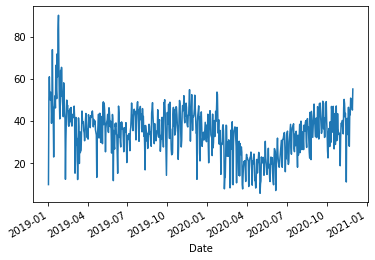

In [11]:
df_normal['Germany/Luxembourg[€/MWh]'].plot()

In [12]:
#Seasonal ARIMA model(SARIMA: Seasonal Auto Regressive Integrated Moving Average) with explanatory variables

from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

<Figure size 432x288 with 0 Axes>

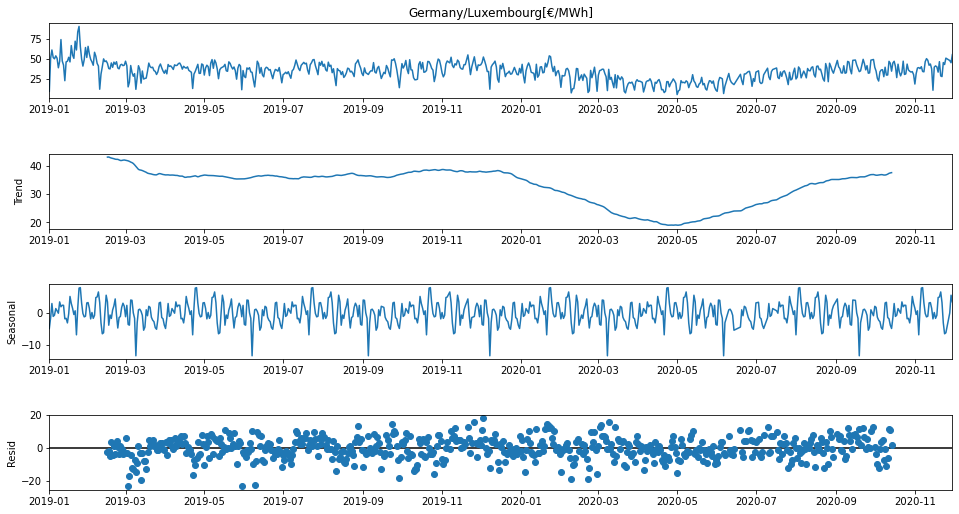

In [13]:
decomposition = seasonal_decompose(df_normal['Germany/Luxembourg[€/MWh]'], period=window)
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

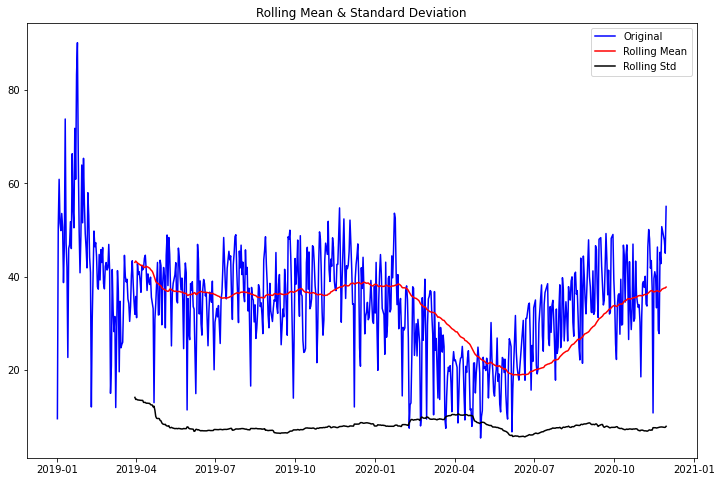

Results of Dickey-Fuller Test:
Test Statistic                  -2.595363
p-value                          0.093959
#Lags Used                      20.000000
Number of Observations Used    655.000000
Critical Value (1%)             -3.440373
Critical Value (5%)             -2.865963
Critical Value (10%)            -2.569125
dtype: float64


In [14]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 


test_stationarity(df_normal['Germany/Luxembourg[€/MWh]'])

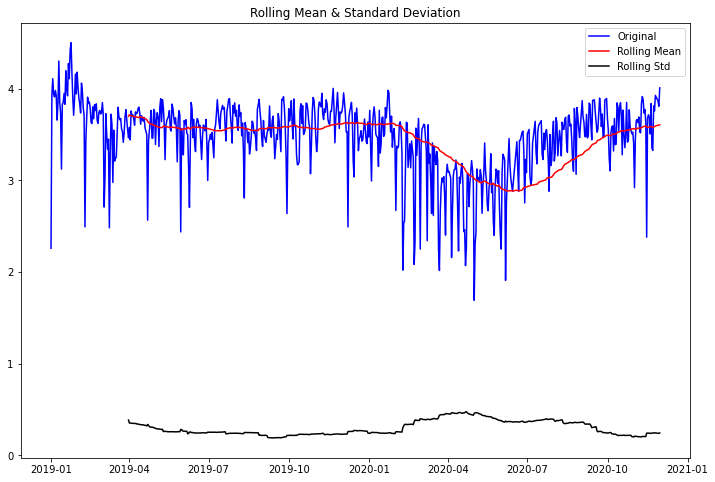

Results of Dickey-Fuller Test:
Test Statistic                  -2.024357
p-value                          0.275997
#Lags Used                      13.000000
Number of Observations Used    662.000000
Critical Value (1%)             -3.440267
Critical Value (5%)             -2.865916
Critical Value (10%)            -2.569100
dtype: float64


In [15]:
df_normal['log(Germany/Luxembourg[€/MWh])']= df_normal['Germany/Luxembourg[€/MWh]'].apply(lambda x: np.log(x))  
test_stationarity(df_normal['log(Germany/Luxembourg[€/MWh])'])
#Worse performance

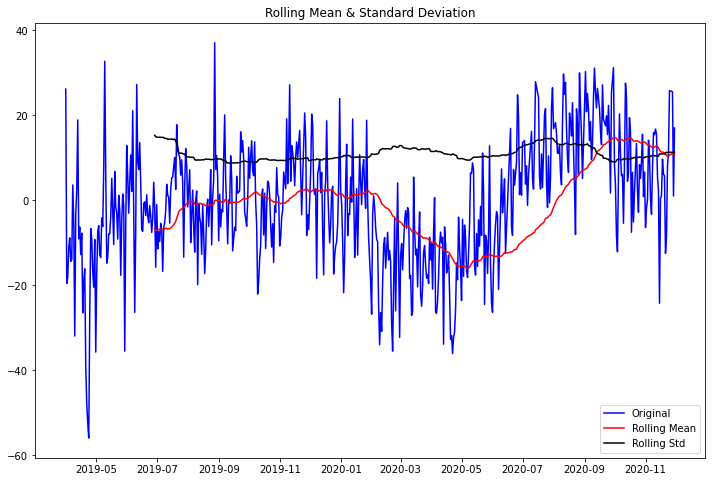

Results of Dickey-Fuller Test:
Test Statistic                  -2.674585
p-value                          0.078540
#Lags Used                      16.000000
Number of Observations Used    569.000000
Critical Value (1%)             -3.441895
Critical Value (5%)             -2.866633
Critical Value (10%)            -2.569482
dtype: float64


In [16]:
df_normal['seasonal_difference'] = df_normal['Germany/Luxembourg[€/MWh]'] - df_normal['Germany/Luxembourg[€/MWh]'].shift(window)  
test_stationarity(df_normal['seasonal_difference'].dropna(inplace=False))
#Much better performance

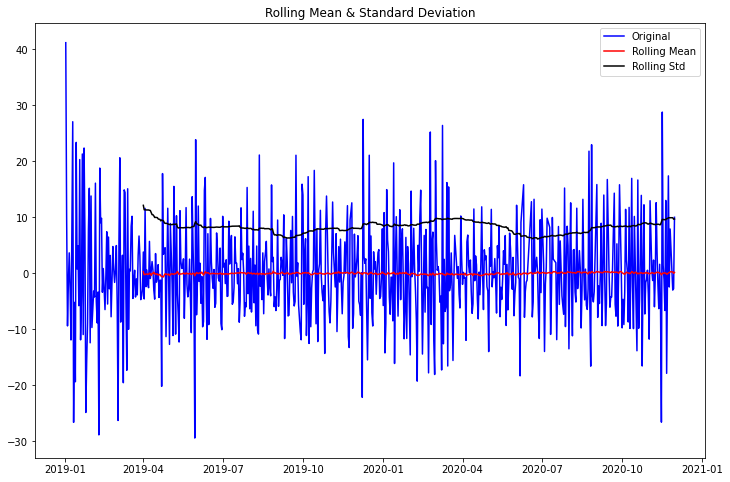

Results of Dickey-Fuller Test:
Test Statistic                -8.450911e+00
p-value                        1.663397e-13
#Lags Used                     1.900000e+01
Number of Observations Used    6.550000e+02
Critical Value (1%)           -3.440373e+00
Critical Value (5%)           -2.865963e+00
Critical Value (10%)          -2.569125e+00
dtype: float64


In [17]:
df_normal['first_difference'] = df_normal['Germany/Luxembourg[€/MWh]'] - df_normal['Germany/Luxembourg[€/MWh]'].shift(1)  
test_stationarity(df_normal['first_difference'].dropna(inplace=False))
#Very significant p-value
#Data normalised 

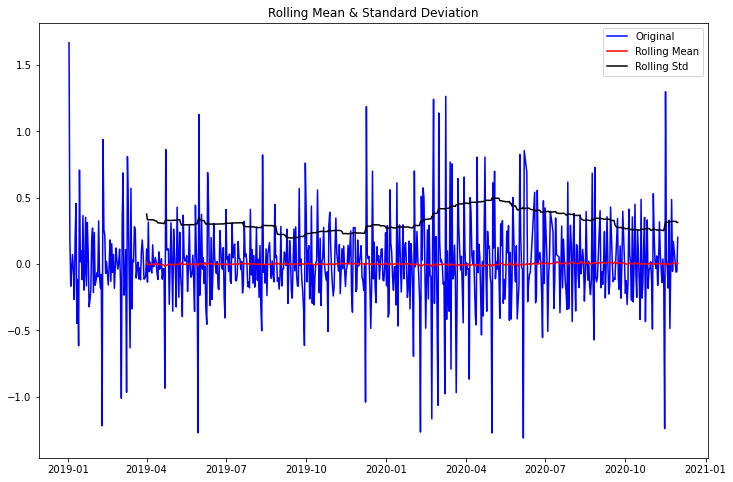

Results of Dickey-Fuller Test:
Test Statistic                -8.246561e+00
p-value                        5.533863e-13
#Lags Used                     1.900000e+01
Number of Observations Used    6.550000e+02
Critical Value (1%)           -3.440373e+00
Critical Value (5%)           -2.865963e+00
Critical Value (10%)          -2.569125e+00
dtype: float64


In [18]:
df_normal['first_difference_log']= df_normal['log(Germany/Luxembourg[€/MWh])'] - df_normal['log(Germany/Luxembourg[€/MWh])'].shift(1)
test_stationarity(df_normal['first_difference_log'].dropna(inplace=False))

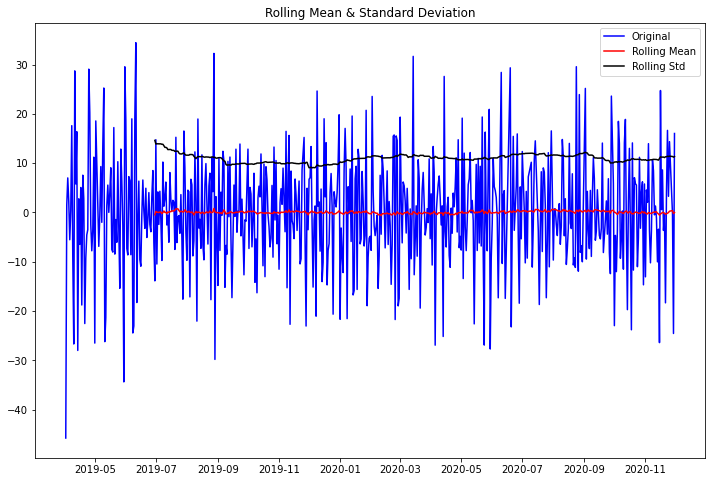

Results of Dickey-Fuller Test:
Test Statistic                -8.662441e+00
p-value                        4.782101e-14
#Lags Used                     1.300000e+01
Number of Observations Used    5.710000e+02
Critical Value (1%)           -3.441854e+00
Critical Value (5%)           -2.866615e+00
Critical Value (10%)          -2.569473e+00
dtype: float64


In [19]:
df_normal['seasonal_first_difference'] = df_normal['first_difference'] - df_normal['first_difference'].shift(window)  
test_stationarity(df_normal.seasonal_first_difference.dropna(inplace=False))
#Very Significant but not as much as the previous one

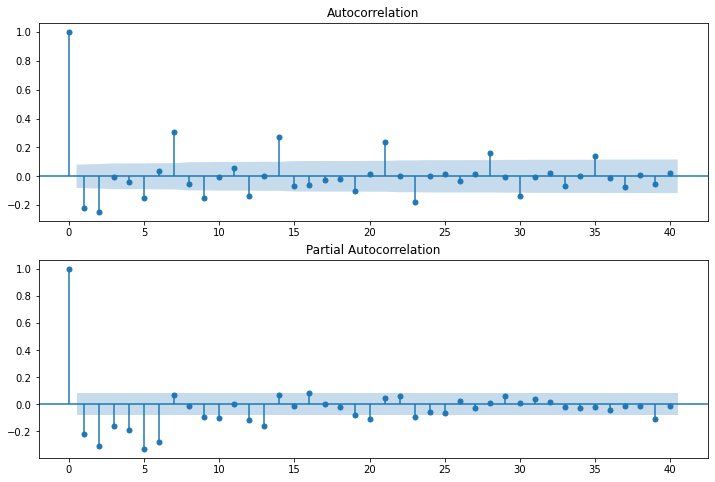

In [20]:
#Model Chosen 'first_difference'
#test_stationarity(df['first_difference'].dropna(inplace=False))

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_normal['first_difference'].iloc[window+1:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_normal['first_difference'].iloc[window+1:], lags=40, ax=ax2)

In [21]:
#Set index to period Day
try:
    df_normal = df_normal.asfreq('D')
    df_normal.index = pd.DatetimeIndex(df.index).to_period('D')
except:
    ar=1
    
p = 7 # This is the maximum degree specification ( indicate number of autoregressive terms (lags of the stationarized series))
d = 1 # Indicate differencing that must be done to stationarize series
q = 1 # Indicate number of moving average terms (lags of the forecast errors)

P = 0
D = 1
Q = 1
s = 7

order = (p,d,q) #1 to get the first difference
seasonal_order = (P,D,Q,s)

mod_sarima = sm.tsa.statespace.SARIMAX(df_normal['Germany/Luxembourg[€/MWh]'], 
                                       order=order, seasonal_order=seasonal_order,simple_differencing=True)


results_sarima = mod_sarima.fit(max_iter=50, method='powell')
results_sarima.summary()
residuals_sarima = results_sarima.resid

#fig, ax = plt.subplots(2,1)
#fig = sm.graphics.tsa.plot_acf(residuals_sarima, lags=50, ax=ax[0])
#fig = sm.graphics.tsa.plot_pacf(residuals_sarima, lags=50, ax=ax[1])
#plt.show()

/home/cronos/.local/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


Optimization terminated successfully.
         Current function value: 3.069115
         Iterations: 4
         Function evaluations: 459


In [22]:
import itertools

def gridsearch_sarima():
    #set parameter range
    p = range(0,3)
    q = range(0,3)
    d = range(0,3)
    s = range(6,8)
    # list of all parameter combos
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = list(itertools.product(p, d, q, s))
    best_results = '' 
    best_aic = 100000000
    # SARIMA model pipeline
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(df_normal['Germany/Luxembourg[€/MWh]'],
                                        order=param,
                                        seasonal_order=param_seasonal)
                results = mod.fit(max_iter = 50, method = 'powell')
                print('SARIMA{},{} - AIC:{}'.format(param, param_seasonal, results.aic))
                if results.aic < best_aic:
                    best_results = 'SARIMA{},{} - AIC:{}'.format(param, param_seasonal, results.aic)
                    best_aic = results.aic
                    best_param = param
                    best_param_seasonal = param_seasonal
            except:
                continue

    print('Best Results: SARIMA{},{} - AIC:{}'.format(best_param,best_param_seasonal, best_aic))
    return best_param, best_param_seasonal

Optimization terminated successfully.
         Current function value: 4.832343
         Iterations: 1
         Function evaluations: 11
SARIMA(0, 0, 0),(0, 0, 0, 6) - AIC:6767.280652130192
Optimization terminated successfully.
         Current function value: 4.832343
         Iterations: 1
         Function evaluations: 11
SARIMA(0, 0, 0),(0, 0, 0, 7) - AIC:6767.280652130192
Optimization terminated successfully.
         Current function value: 4.407098
         Iterations: 3
         Function evaluations: 81
SARIMA(0, 0, 0),(0, 0, 1, 6) - AIC:6173.936822631873
Optimization terminated successfully.
         Current function value: 4.399165
         Iterations: 3
         Function evaluations: 86
SARIMA(0, 0, 0),(0, 0, 1, 7) - AIC:6162.830938320643
Optimization terminated successfully.
         Current function value: 4.138288
         Iterations: 3
         Function evaluations: 111
SARIMA(0, 0, 0),(0, 0, 2, 6) - AIC:5799.603022010289
Optimization terminated successfully.
         Cu

SARIMA(0, 0, 0),(2, 1, 0, 7) - AIC:4735.462968166652
Optimization terminated successfully.
         Current function value: 3.478717
         Iterations: 4
         Function evaluations: 191
SARIMA(0, 0, 0),(2, 1, 1, 6) - AIC:4878.203799154833
Optimization terminated successfully.
         Current function value: 3.355032
         Iterations: 5
         Function evaluations: 247
SARIMA(0, 0, 0),(2, 1, 1, 7) - AIC:4705.044185953344
Optimization terminated successfully.
         Current function value: 3.478655
         Iterations: 3
         Function evaluations: 176
SARIMA(0, 0, 0),(2, 1, 2, 6) - AIC:4880.116936241364
Optimization terminated successfully.
         Current function value: 3.353605
         Iterations: 3
         Function evaluations: 180
SARIMA(0, 0, 0),(2, 1, 2, 7) - AIC:4705.046435201753
Optimization terminated successfully.
         Current function value: 3.755325
         Iterations: 2
         Function evaluations: 72
SARIMA(0, 0, 0),(2, 2, 0, 6) - AIC:5263.455481

SARIMA(0, 0, 1),(1, 2, 1, 6) - AIC:4881.39958940181
Optimization terminated successfully.
         Current function value: 3.307349
         Iterations: 3
         Function evaluations: 170
SARIMA(0, 0, 1),(1, 2, 1, 7) - AIC:4638.288371029414
Optimization terminated successfully.
         Current function value: 3.393828
         Iterations: 5
         Function evaluations: 351
SARIMA(0, 0, 1),(1, 2, 2, 6) - AIC:4761.359821247954
Optimization terminated successfully.
         Current function value: 3.259214
         Iterations: 5
         Function evaluations: 369
SARIMA(0, 0, 1),(1, 2, 2, 7) - AIC:4572.898932030203
Optimization terminated successfully.
         Current function value: 3.519145
         Iterations: 4
         Function evaluations: 208
SARIMA(0, 0, 1),(2, 0, 0, 6) - AIC:4934.80247230615
Optimization terminated successfully.
         Current function value: 3.355220
         Iterations: 4
         Function evaluations: 195
SARIMA(0, 0, 1),(2, 0, 0, 7) - AIC:4705.3076679

Optimization terminated successfully.
         Current function value: 3.420127
         Iterations: 4
         Function evaluations: 295
SARIMA(0, 0, 2),(1, 0, 2, 6) - AIC:4800.177612690895
Optimization terminated successfully.
         Current function value: 3.270478
         Iterations: 4
         Function evaluations: 286
SARIMA(0, 0, 2),(1, 0, 2, 7) - AIC:4590.669770087516
Optimization terminated successfully.
         Current function value: 3.484146
         Iterations: 3
         Function evaluations: 146
SARIMA(0, 0, 2),(1, 1, 0, 6) - AIC:4885.804582884189
Optimization terminated successfully.
         Current function value: 3.288549
         Iterations: 2
         Function evaluations: 94
SARIMA(0, 0, 2),(1, 1, 0, 7) - AIC:4611.968859547765
Optimization terminated successfully.
         Current function value: 3.380768
         Iterations: 4
         Function evaluations: 232
SARIMA(0, 0, 2),(1, 1, 1, 6) - AIC:4743.0748820118315
Optimization terminated successfully.
       

Optimization terminated successfully.
         Current function value: 3.294569
         Iterations: 2
         Function evaluations: 79
SARIMA(0, 1, 0),(0, 1, 2, 7) - AIC:4618.3959689366275
Optimization terminated successfully.
         Current function value: 4.228752
         Iterations: 2
         Function evaluations: 36
SARIMA(0, 1, 0),(0, 2, 0, 6) - AIC:5922.252855255738
Optimization terminated successfully.
         Current function value: 4.062847
         Iterations: 2
         Function evaluations: 43
SARIMA(0, 1, 0),(0, 2, 0, 7) - AIC:5689.9860374636555
Optimization terminated successfully.
         Current function value: 3.763223
         Iterations: 3
         Function evaluations: 93
SARIMA(0, 1, 0),(0, 2, 1, 6) - AIC:5272.511770299643
Optimization terminated successfully.
         Current function value: 3.561985
         Iterations: 3
         Function evaluations: 92
SARIMA(0, 1, 0),(0, 2, 1, 7) - AIC:4990.779011669796
Optimization terminated successfully.
         C

SARIMA(0, 1, 1),(0, 0, 0, 6) - AIC:4760.349046056783
Optimization terminated successfully.
         Current function value: 3.397392
         Iterations: 2
         Function evaluations: 62
SARIMA(0, 1, 1),(0, 0, 0, 7) - AIC:4760.349046056783
Optimization terminated successfully.
         Current function value: 3.393621
         Iterations: 2
         Function evaluations: 77
SARIMA(0, 1, 1),(0, 0, 1, 6) - AIC:4757.0687881406
Optimization terminated successfully.
         Current function value: 3.365695
         Iterations: 2
         Function evaluations: 76
SARIMA(0, 1, 1),(0, 0, 1, 7) - AIC:4717.973046324147
Optimization terminated successfully.
         Current function value: 3.390684
         Iterations: 2
         Function evaluations: 97
SARIMA(0, 1, 1),(0, 0, 2, 6) - AIC:4754.958271737531
Optimization terminated successfully.
         Current function value: 3.333687
         Iterations: 2
         Function evaluations: 90
SARIMA(0, 1, 1),(0, 0, 2, 7) - AIC:4675.161765593803

SARIMA(0, 1, 1),(2, 1, 0, 7) - AIC:4604.7265589426715
Optimization terminated successfully.
         Current function value: 3.384043
         Iterations: 11
         Function evaluations: 669
SARIMA(0, 1, 1),(2, 1, 1, 6) - AIC:4747.66043478185
Optimization terminated successfully.
         Current function value: 3.200834
         Iterations: 8
         Function evaluations: 487
SARIMA(0, 1, 1),(2, 1, 1, 7) - AIC:4491.167214852474
Optimization terminated successfully.
         Current function value: 3.387365
         Iterations: 5
         Function evaluations: 407
SARIMA(0, 1, 1),(2, 1, 2, 6) - AIC:4754.31075045418
Optimization terminated successfully.
         Current function value: 3.201166
         Iterations: 5
         Function evaluations: 369
SARIMA(0, 1, 1),(2, 1, 2, 7) - AIC:4493.632138965868
Optimization terminated successfully.
         Current function value: 3.756261
         Iterations: 3
         Function evaluations: 192
SARIMA(0, 1, 1),(2, 2, 0, 6) - AIC:5266.76518

SARIMA(0, 1, 2),(1, 2, 1, 6) - AIC:4889.798328543657
Optimization terminated successfully.
         Current function value: 3.304602
         Iterations: 3
         Function evaluations: 199
SARIMA(0, 1, 2),(1, 2, 1, 7) - AIC:4636.442772915119
Optimization terminated successfully.
         Current function value: 3.393769
         Iterations: 6
         Function evaluations: 538
SARIMA(0, 1, 2),(1, 2, 2, 6) - AIC:4763.277251893369
Optimization terminated successfully.
         Current function value: 3.198998
         Iterations: 5
         Function evaluations: 368
SARIMA(0, 1, 2),(1, 2, 2, 7) - AIC:4490.596947975032
Optimization terminated successfully.
         Current function value: 3.333508
         Iterations: 2
         Function evaluations: 121
SARIMA(0, 1, 2),(2, 0, 0, 6) - AIC:4676.910639312341
Optimization terminated successfully.
         Current function value: 3.260120
         Iterations: 2
         Function evaluations: 116
SARIMA(0, 1, 2),(2, 0, 0, 7) - AIC:4574.16866

Optimization terminated successfully.
         Current function value: 3.887683
         Iterations: 2
         Function evaluations: 92
SARIMA(0, 2, 0),(1, 0, 2, 6) - AIC:5450.755724464139
Optimization terminated successfully.
         Current function value: 3.780155
         Iterations: 9
         Function evaluations: 447
SARIMA(0, 2, 0),(1, 0, 2, 7) - AIC:5300.216959222793
Optimization terminated successfully.
         Current function value: 4.113151
         Iterations: 2
         Function evaluations: 51
SARIMA(0, 2, 0),(1, 1, 0, 6) - AIC:5762.411860325237
Optimization terminated successfully.
         Current function value: 3.877609
         Iterations: 2
         Function evaluations: 48
SARIMA(0, 2, 0),(1, 1, 0, 7) - AIC:5432.652309758841
Optimization terminated successfully.
         Current function value: 3.887442
         Iterations: 3
         Function evaluations: 104
SARIMA(0, 2, 0),(1, 1, 1, 6) - AIC:5448.419119657268
Optimization terminated successfully.
         C

Optimization terminated successfully.
         Current function value: 3.298569
         Iterations: 3
         Function evaluations: 208
SARIMA(0, 2, 1),(0, 1, 2, 7) - AIC:4625.995915359963
Optimization terminated successfully.
         Current function value: 4.227770
         Iterations: 2
         Function evaluations: 85
SARIMA(0, 2, 1),(0, 2, 0, 6) - AIC:5922.877777443491
Optimization terminated successfully.
         Current function value: 4.062137
         Iterations: 2
         Function evaluations: 74
SARIMA(0, 2, 1),(0, 2, 0, 7) - AIC:5690.99190987315
Optimization terminated successfully.
         Current function value: 3.767920
         Iterations: 3
         Function evaluations: 173
SARIMA(0, 2, 1),(0, 2, 1, 6) - AIC:5281.087374643943
Optimization terminated successfully.
         Current function value: 3.566798
         Iterations: 3
         Function evaluations: 165
SARIMA(0, 2, 1),(0, 2, 1, 7) - AIC:4999.517189175234
Optimization terminated successfully.
         C

Optimization terminated successfully.
         Current function value: 3.400079
         Iterations: 3
         Function evaluations: 130
SARIMA(0, 2, 2),(0, 0, 0, 6) - AIC:4766.1107374129015
Optimization terminated successfully.
         Current function value: 3.400079
         Iterations: 3
         Function evaluations: 130
SARIMA(0, 2, 2),(0, 0, 0, 7) - AIC:4766.1107374129015
Optimization terminated successfully.
         Current function value: 3.396263
         Iterations: 3
         Function evaluations: 165
SARIMA(0, 2, 2),(0, 0, 1, 6) - AIC:4762.768807868589
Optimization terminated successfully.
         Current function value: 3.367955
         Iterations: 3
         Function evaluations: 167
SARIMA(0, 2, 2),(0, 0, 1, 7) - AIC:4723.137543700023
Optimization terminated successfully.
         Current function value: 3.393419
         Iterations: 3
         Function evaluations: 198
SARIMA(0, 2, 2),(0, 0, 2, 6) - AIC:4760.786054132137
Optimization terminated successfully.
     

Optimization terminated successfully.
         Current function value: 3.286098
         Iterations: 3
         Function evaluations: 213
SARIMA(0, 2, 2),(2, 1, 0, 7) - AIC:4610.536749562423
Optimization terminated successfully.
         Current function value: 3.390834
         Iterations: 5
         Function evaluations: 399
SARIMA(0, 2, 2),(2, 1, 1, 6) - AIC:4759.167164948435
Optimization terminated successfully.
         Current function value: 3.207026
         Iterations: 8
         Function evaluations: 633
SARIMA(0, 2, 2),(2, 1, 1, 7) - AIC:4501.835818915357
Optimization terminated successfully.
         Current function value: 3.394308
         Iterations: 5
         Function evaluations: 516
SARIMA(0, 2, 2),(2, 1, 2, 6) - AIC:4766.031259127718
Optimization terminated successfully.
         Current function value: 3.207527
         Iterations: 5
         Function evaluations: 483
SARIMA(0, 2, 2),(2, 1, 2, 7) - AIC:4504.537523894487
Optimization terminated successfully.
       

Optimization terminated successfully.
         Current function value: 3.491350
         Iterations: 3
         Function evaluations: 172
SARIMA(1, 0, 0),(1, 2, 1, 6) - AIC:4895.890350674838
Optimization terminated successfully.
         Current function value: 3.276143
         Iterations: 3
         Function evaluations: 176
SARIMA(1, 0, 0),(1, 2, 1, 7) - AIC:4594.599764628686
Optimization terminated successfully.
         Current function value: 3.386359
         Iterations: 5
         Function evaluations: 361
SARIMA(1, 0, 0),(1, 2, 2, 6) - AIC:4750.902873068717
Optimization terminated successfully.
         Current function value: 3.209949
         Iterations: 5
         Function evaluations: 379
SARIMA(1, 0, 0),(1, 2, 2, 7) - AIC:4503.928189665085
Optimization terminated successfully.
         Current function value: 3.526863
         Iterations: 3
         Function evaluations: 155
SARIMA(1, 0, 0),(2, 0, 0, 6) - AIC:4945.608690128988
Optimization terminated successfully.
       

Optimization terminated successfully.
         Current function value: 3.227173
         Iterations: 4
         Function evaluations: 239
SARIMA(1, 0, 1),(1, 0, 1, 7) - AIC:4528.041602739372
Optimization terminated successfully.
         Current function value: 3.412101
         Iterations: 4
         Function evaluations: 290
SARIMA(1, 0, 1),(1, 0, 2, 6) - AIC:4788.941852456544
Optimization terminated successfully.
         Current function value: 3.227079
         Iterations: 4
         Function evaluations: 273
SARIMA(1, 0, 1),(1, 0, 2, 7) - AIC:4529.910065667082
Optimization terminated successfully.
         Current function value: 3.483953
         Iterations: 5
         Function evaluations: 246
SARIMA(1, 0, 1),(1, 1, 0, 6) - AIC:4885.534800828084
Optimization terminated successfully.
         Current function value: 3.274188
         Iterations: 2
         Function evaluations: 95
SARIMA(1, 0, 1),(1, 1, 0, 7) - AIC:4591.86274115909
Optimization terminated successfully.
         

/home/cronos/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/cronos/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Optimization terminated successfully.
         Current function value: 3.573809
         Iterations: 2
         Function evaluations: 101
SARIMA(1, 0, 2),(0, 1, 0, 6) - AIC:5011.333042871396
Optimization terminated successfully.
         Current function value: 3.410494
         Iterations: 3
         Function evaluations: 149
SARIMA(1, 0, 2),(0, 1, 0, 7) - AIC:4782.691400148376
Optimization terminated successfully.
         Current function value: 3.330448
         Iterations: 9
         Function evaluations: 547
SARIMA(1, 0, 2),(0, 1, 1, 6) - AIC:4672.627500594931
Optimization terminated successfully.
         Current function value: 3.177068
         Iterations: 6
         Function evaluations: 355
SARIMA(1, 0, 2),(0, 1, 1, 7) - AIC:4457.894666151317
Optimization terminated successfully.
         Current function value: 3.328551
         Iterations: 9
         Function evaluations: 648
SARIMA(1, 0, 2),(0, 1, 2, 6) - AIC:4671.972066185119
Optimization terminated successfully.
       

Optimization terminated successfully.
         Current function value: 3.488245
         Iterations: 5
         Function evaluations: 369
SARIMA(1, 0, 2),(2, 2, 0, 7) - AIC:4895.543136626509
Optimization terminated successfully.
         Current function value: 3.434541
         Iterations: 4
         Function evaluations: 359
SARIMA(1, 0, 2),(2, 2, 1, 6) - AIC:4822.357976778193
Optimization terminated successfully.
         Current function value: 3.241712
         Iterations: 5
         Function evaluations: 455
SARIMA(1, 0, 2),(2, 2, 1, 7) - AIC:4552.396928540635
Optimization terminated successfully.
         Current function value: 3.381020
         Iterations: 9
         Function evaluations: 910
SARIMA(1, 0, 2),(2, 2, 2, 6) - AIC:4749.427826191339
Optimization terminated successfully.
         Current function value: 3.188834
         Iterations: 10
         Function evaluations: 1012
SARIMA(1, 0, 2),(2, 2, 2, 7) - AIC:4480.367480049915
Optimization terminated successfully.
     

Optimization terminated successfully.
         Current function value: 3.444942
         Iterations: 2
         Function evaluations: 117
SARIMA(1, 1, 0),(2, 0, 1, 6) - AIC:4832.919473389289
Optimization terminated successfully.
         Current function value: 3.279280
         Iterations: 8
         Function evaluations: 486
SARIMA(1, 1, 0),(2, 0, 1, 7) - AIC:4600.992178380099
Optimization terminated successfully.
         Current function value: 3.444417
         Iterations: 2
         Function evaluations: 145
SARIMA(1, 1, 0),(2, 0, 2, 6) - AIC:4834.1835393208
Optimization terminated successfully.
         Current function value: 3.278490
         Iterations: 5
         Function evaluations: 369
SARIMA(1, 1, 0),(2, 0, 2, 7) - AIC:4601.886164334197
Optimization terminated successfully.
         Current function value: 3.568128
         Iterations: 2
         Function evaluations: 98
SARIMA(1, 1, 0),(2, 1, 0, 6) - AIC:5003.37909540452
Optimization terminated successfully.
         Cu

Optimization terminated successfully.
         Current function value: 3.173643
         Iterations: 5
         Function evaluations: 305
SARIMA(1, 1, 1),(1, 1, 1, 7) - AIC:4453.1003405224965
Optimization terminated successfully.
         Current function value: 3.334506
         Iterations: 6
         Function evaluations: 490
SARIMA(1, 1, 1),(1, 1, 2, 6) - AIC:4680.308099454035
Optimization terminated successfully.
         Current function value: 3.174253
         Iterations: 4
         Function evaluations: 299
SARIMA(1, 1, 1),(1, 1, 2, 7) - AIC:4455.954485565768
Optimization terminated successfully.
         Current function value: 3.817956
         Iterations: 3
         Function evaluations: 188
SARIMA(1, 1, 1),(1, 2, 0, 6) - AIC:5353.138100081582
Optimization terminated successfully.
         Current function value: 3.593068
         Iterations: 5
         Function evaluations: 267
SARIMA(1, 1, 1),(1, 2, 0, 7) - AIC:5038.2948801530665
Optimization terminated successfully.
     

Optimization terminated successfully.
         Current function value: 3.388051
         Iterations: 9
         Function evaluations: 809
SARIMA(1, 1, 2),(0, 2, 2, 6) - AIC:4755.271125127616
Optimization terminated successfully.
         Current function value: 3.201258
         Iterations: 5
         Function evaluations: 412
SARIMA(1, 1, 2),(0, 2, 2, 7) - AIC:4493.7613846576805
Optimization terminated successfully.
         Current function value: 3.335718
         Iterations: 2
         Function evaluations: 113
SARIMA(1, 1, 2),(1, 0, 0, 6) - AIC:4680.005771172467
Optimization terminated successfully.
         Current function value: 3.284479
         Iterations: 4
         Function evaluations: 247
SARIMA(1, 1, 2),(1, 0, 0, 7) - AIC:4608.270579160444
Optimization terminated successfully.
         Current function value: 3.334655
         Iterations: 2
         Function evaluations: 143
SARIMA(1, 1, 2),(1, 0, 1, 6) - AIC:4680.516376073698
Optimization terminated successfully.
      

Optimization terminated successfully.
         Current function value: 3.684811
         Iterations: 2
         Function evaluations: 92
SARIMA(1, 2, 0),(0, 0, 2, 7) - AIC:5166.735457603266
Optimization terminated successfully.
         Current function value: 4.060847
         Iterations: 2
         Function evaluations: 47
SARIMA(1, 2, 0),(0, 1, 0, 6) - AIC:5689.185453463487
Optimization terminated successfully.
         Current function value: 3.820649
         Iterations: 2
         Function evaluations: 51
SARIMA(1, 2, 0),(0, 1, 0, 7) - AIC:5352.908622298641
Optimization terminated successfully.
         Current function value: 3.755418
         Iterations: 3
         Function evaluations: 128
SARIMA(1, 2, 0),(0, 1, 1, 6) - AIC:5263.585659151637
Optimization terminated successfully.
         Current function value: 3.553085
         Iterations: 3
         Function evaluations: 114
SARIMA(1, 2, 0),(0, 1, 1, 7) - AIC:4980.319301148662
Optimization terminated successfully.
         C

Optimization terminated successfully.
         Current function value: 4.133809
         Iterations: 3
         Function evaluations: 152
SARIMA(1, 2, 0),(2, 2, 0, 6) - AIC:5795.332526443059
Optimization terminated successfully.
         Current function value: 3.888557
         Iterations: 2
         Function evaluations: 99
SARIMA(1, 2, 0),(2, 2, 0, 7) - AIC:5451.979426684834
Optimization terminated successfully.
         Current function value: 3.842548
         Iterations: 4
         Function evaluations: 290
SARIMA(1, 2, 0),(2, 2, 1, 6) - AIC:5389.567759921221
Optimization terminated successfully.
         Current function value: 3.621767
         Iterations: 3
         Function evaluations: 210
SARIMA(1, 2, 0),(2, 2, 1, 7) - AIC:5080.4732843102065
Optimization terminated successfully.
         Current function value: 3.744669
         Iterations: 13
         Function evaluations: 982
SARIMA(1, 2, 0),(2, 2, 2, 6) - AIC:5254.536247854561
Optimization terminated successfully.
      

Optimization terminated successfully.
         Current function value: 3.332323
         Iterations: 3
         Function evaluations: 225
SARIMA(1, 2, 1),(2, 0, 0, 7) - AIC:4675.251789679804
Optimization terminated successfully.
         Current function value: 3.445849
         Iterations: 3
         Function evaluations: 248
SARIMA(1, 2, 1),(2, 0, 1, 6) - AIC:4836.189036714078
Optimization terminated successfully.
         Current function value: 3.277461
         Iterations: 8
         Function evaluations: 643
SARIMA(1, 2, 1),(2, 0, 1, 7) - AIC:4600.44553212012
Optimization terminated successfully.
         Current function value: 3.443647
         Iterations: 3
         Function evaluations: 283
SARIMA(1, 2, 1),(2, 0, 2, 6) - AIC:4835.105880926293
Optimization terminated successfully.
         Current function value: 3.276516
         Iterations: 5
         Function evaluations: 488
SARIMA(1, 2, 1),(2, 0, 2, 7) - AIC:4601.122546448409
Optimization terminated successfully.
        

Optimization terminated successfully.
         Current function value: 3.478160
         Iterations: 4
         Function evaluations: 348
SARIMA(1, 2, 2),(1, 1, 1, 6) - AIC:4881.423813767804
Optimization terminated successfully.
         Current function value: 3.180696
         Iterations: 5
         Function evaluations: 369
SARIMA(1, 2, 2),(1, 1, 1, 7) - AIC:4464.973754134462
Optimization terminated successfully.
         Current function value: 3.473318
         Iterations: 3
         Function evaluations: 297
SARIMA(1, 2, 2),(1, 1, 2, 6) - AIC:4876.645230409428
Optimization terminated successfully.
         Current function value: 3.181082
         Iterations: 4
         Function evaluations: 368
SARIMA(1, 2, 2),(1, 1, 2, 7) - AIC:4467.514993409199
Optimization terminated successfully.
         Current function value: 3.825650
         Iterations: 7
         Function evaluations: 509
SARIMA(1, 2, 2),(1, 2, 0, 6) - AIC:5365.909671075518
Optimization terminated successfully.
       

Optimization terminated successfully.
         Current function value: 3.402889
         Iterations: 3
         Function evaluations: 162
SARIMA(2, 0, 0),(0, 2, 1, 7) - AIC:4772.044376821137
Optimization terminated successfully.
         Current function value: 3.387934
         Iterations: 4
         Function evaluations: 252
SARIMA(2, 0, 0),(0, 2, 2, 6) - AIC:4753.106960226745
Optimization terminated successfully.
         Current function value: 3.201862
         Iterations: 4
         Function evaluations: 247
SARIMA(2, 0, 0),(0, 2, 2, 7) - AIC:4492.606414381546
Optimization terminated successfully.
         Current function value: 3.596247
         Iterations: 3
         Function evaluations: 141
SARIMA(2, 0, 0),(1, 0, 0, 6) - AIC:5042.745170289345
Optimization terminated successfully.
         Current function value: 3.380281
         Iterations: 11
         Function evaluations: 553
SARIMA(2, 0, 0),(1, 0, 0, 7) - AIC:4740.393291261859
Optimization terminated successfully.
      

Optimization terminated successfully.
         Current function value: 3.345013
         Iterations: 9
         Function evaluations: 626
SARIMA(2, 0, 1),(0, 0, 2, 6) - AIC:4695.018157828044
Optimization terminated successfully.
         Current function value: 3.283956
         Iterations: 10
         Function evaluations: 725
SARIMA(2, 0, 1),(0, 0, 2, 7) - AIC:4609.538227578076
Optimization terminated successfully.
         Current function value: 3.574987
         Iterations: 2
         Function evaluations: 101
SARIMA(2, 0, 1),(0, 1, 0, 6) - AIC:5012.981153267496
Optimization terminated successfully.
         Current function value: 3.410735
         Iterations: 1
         Function evaluations: 46
SARIMA(2, 0, 1),(0, 1, 0, 7) - AIC:4783.029161187455
Optimization terminated successfully.
         Current function value: 3.378853
         Iterations: 3
         Function evaluations: 179
SARIMA(2, 0, 1),(0, 1, 1, 6) - AIC:4740.394106178988
Optimization terminated successfully.
       

Optimization terminated successfully.
         Current function value: 3.191051
         Iterations: 4
         Function evaluations: 379
SARIMA(2, 0, 1),(2, 1, 2, 7) - AIC:4483.472072779041
Optimization terminated successfully.
         Current function value: 3.688841
         Iterations: 3
         Function evaluations: 216
SARIMA(2, 0, 1),(2, 2, 0, 6) - AIC:5176.377157000154
Optimization terminated successfully.
         Current function value: 3.489981
         Iterations: 3
         Function evaluations: 216
SARIMA(2, 0, 1),(2, 2, 0, 7) - AIC:4897.9735382004255
Optimization terminated successfully.
         Current function value: 3.433670
         Iterations: 4
         Function evaluations: 367
SARIMA(2, 0, 1),(2, 2, 1, 6) - AIC:4821.1386415206225
Optimization terminated successfully.
         Current function value: 3.245197
         Iterations: 4
         Function evaluations: 357
SARIMA(2, 0, 1),(2, 2, 1, 7) - AIC:4557.2762505802675
Optimization terminated successfully.
    

Optimization terminated successfully.
         Current function value: 3.339756
         Iterations: 10
         Function evaluations: 828
SARIMA(2, 0, 2),(2, 0, 0, 6) - AIC:4689.658387482927
Optimization terminated successfully.
         Current function value: 3.253328
         Iterations: 9
         Function evaluations: 752
SARIMA(2, 0, 2),(2, 0, 0, 7) - AIC:4568.658528869086
Optimization terminated successfully.
         Current function value: 3.342953
         Iterations: 9
         Function evaluations: 864
SARIMA(2, 0, 2),(2, 0, 1, 6) - AIC:4696.13361444301
Optimization terminated successfully.
         Current function value: 3.205902
         Iterations: 9
         Function evaluations: 819
SARIMA(2, 0, 2),(2, 0, 1, 7) - AIC:4504.262522111619
Optimization terminated successfully.
         Current function value: 3.342121
         Iterations: 8
         Function evaluations: 835
SARIMA(2, 0, 2),(2, 0, 2, 6) - AIC:4696.9689702693095
Optimization terminated successfully.
      

Optimization terminated successfully.
         Current function value: 3.340839
         Iterations: 2
         Function evaluations: 94
SARIMA(2, 1, 0),(1, 1, 0, 7) - AIC:4685.173922929139
Optimization terminated successfully.
         Current function value: 3.411029
         Iterations: 4
         Function evaluations: 250
SARIMA(2, 1, 0),(1, 1, 1, 6) - AIC:4785.4407986942
Optimization terminated successfully.
         Current function value: 3.222221
         Iterations: 5
         Function evaluations: 309
SARIMA(2, 1, 0),(1, 1, 1, 7) - AIC:4521.10873549037
Optimization terminated successfully.
         Current function value: 3.410093
         Iterations: 3
         Function evaluations: 225
SARIMA(2, 1, 0),(1, 1, 2, 6) - AIC:4786.130105038286
Optimization terminated successfully.
         Current function value: 3.222770
         Iterations: 4
         Function evaluations: 294
SARIMA(2, 1, 0),(1, 1, 2, 7) - AIC:4523.878125706217
Optimization terminated successfully.
         Cu

Optimization terminated successfully.
         Current function value: 3.571915
         Iterations: 5
         Function evaluations: 377
SARIMA(2, 1, 1),(0, 2, 1, 6) - AIC:5010.680979953014
Optimization terminated successfully.
         Current function value: 3.406718
         Iterations: 4
         Function evaluations: 302
SARIMA(2, 1, 1),(0, 2, 1, 7) - AIC:4779.404890446449
Optimization terminated successfully.
         Current function value: 3.347181
         Iterations: 5
         Function evaluations: 400
SARIMA(2, 1, 1),(0, 2, 2, 6) - AIC:4698.0528644378865
Optimization terminated successfully.
         Current function value: 3.191901
         Iterations: 6
         Function evaluations: 494
SARIMA(2, 1, 1),(0, 2, 2, 7) - AIC:4480.661703489133
Optimization terminated successfully.
         Current function value: 3.334866
         Iterations: 3
         Function evaluations: 184
SARIMA(2, 1, 1),(1, 0, 0, 6) - AIC:4678.8118075769
Optimization terminated successfully.
        

Optimization terminated successfully.
         Current function value: 3.307431
         Iterations: 4
         Function evaluations: 282
SARIMA(2, 1, 2),(0, 0, 1, 7) - AIC:4642.403756883506
Optimization terminated successfully.
         Current function value: 3.333462
         Iterations: 4
         Function evaluations: 322
SARIMA(2, 1, 2),(0, 0, 2, 6) - AIC:4680.846565647352
Optimization terminated successfully.
         Current function value: 3.276117
         Iterations: 5
         Function evaluations: 411
SARIMA(2, 1, 2),(0, 0, 2, 7) - AIC:4600.563414755625
Optimization terminated successfully.
         Current function value: 3.523229
         Iterations: 3
         Function evaluations: 183
SARIMA(2, 1, 2),(0, 1, 0, 6) - AIC:4942.52016152083
Optimization terminated successfully.
         Current function value: 3.412736
         Iterations: 2
         Function evaluations: 187
SARIMA(2, 1, 2),(0, 1, 0, 7) - AIC:4787.830043894695
Optimization terminated successfully.
        

Optimization terminated successfully.
         Current function value: 3.329898
         Iterations: 9
         Function evaluations: 957
SARIMA(2, 1, 2),(2, 1, 2, 6) - AIC:4679.8574610666765
Optimization terminated successfully.
         Current function value: 3.169950
         Iterations: 7
         Function evaluations: 771
SARIMA(2, 1, 2),(2, 1, 2, 7) - AIC:4455.929389178368
Optimization terminated successfully.
         Current function value: 3.686741
         Iterations: 5
         Function evaluations: 425
SARIMA(2, 1, 2),(2, 2, 0, 6) - AIC:5175.4374774984335
Optimization terminated successfully.
         Current function value: 3.489305
         Iterations: 3
         Function evaluations: 311
SARIMA(2, 1, 2),(2, 2, 0, 7) - AIC:4899.026578935512
Optimization terminated successfully.
         Current function value: 3.438630
         Iterations: 5
         Function evaluations: 513
SARIMA(2, 1, 2),(2, 2, 1, 6) - AIC:4830.082563600106
Optimization terminated successfully.
     

Optimization terminated successfully.
         Current function value: 3.468084
         Iterations: 4
         Function evaluations: 360
SARIMA(2, 2, 0),(1, 2, 2, 7) - AIC:4867.3180090374535
Optimization terminated successfully.
         Current function value: 3.655474
         Iterations: 3
         Function evaluations: 174
SARIMA(2, 2, 0),(2, 0, 0, 6) - AIC:5127.664100421096
Optimization terminated successfully.
         Current function value: 3.542931
         Iterations: 3
         Function evaluations: 188
SARIMA(2, 2, 0),(2, 0, 0, 7) - AIC:4970.103790331143
Optimization terminated successfully.
         Current function value: 3.655490
         Iterations: 2
         Function evaluations: 140
SARIMA(2, 2, 0),(2, 0, 1, 6) - AIC:5129.68617498265
Optimization terminated successfully.
         Current function value: 3.488863
         Iterations: 10
         Function evaluations: 705
SARIMA(2, 2, 0),(2, 0, 1, 7) - AIC:4896.407981166096
Optimization terminated successfully.
      

Optimization terminated successfully.
         Current function value: 3.586061
         Iterations: 3
         Function evaluations: 218
SARIMA(2, 2, 1),(1, 1, 0, 6) - AIC:5030.485890513357
Optimization terminated successfully.
         Current function value: 3.342528
         Iterations: 3
         Function evaluations: 224
SARIMA(2, 2, 1),(1, 1, 0, 7) - AIC:4689.539469581034
Optimization terminated successfully.
         Current function value: 3.416897
         Iterations: 4
         Function evaluations: 333
SARIMA(2, 2, 1),(1, 1, 1, 6) - AIC:4795.655158187805
Optimization terminated successfully.
         Current function value: 3.228060
         Iterations: 5
         Function evaluations: 419
SARIMA(2, 2, 1),(1, 1, 1, 7) - AIC:4531.283831871312
Optimization terminated successfully.
         Current function value: 3.416082
         Iterations: 3
         Function evaluations: 303
SARIMA(2, 2, 1),(1, 1, 2, 6) - AIC:4796.514202353416
Optimization terminated successfully.
       

Optimization terminated successfully.
         Current function value: 3.899276
         Iterations: 13
         Function evaluations: 835
SARIMA(2, 2, 2),(0, 2, 0, 7) - AIC:5468.98665301835
Optimization terminated successfully.
         Current function value: 3.582879
         Iterations: 12
         Function evaluations: 1026
SARIMA(2, 2, 2),(0, 2, 1, 6) - AIC:5028.029965071533
Optimization terminated successfully.
         Current function value: 3.417206
         Iterations: 14
         Function evaluations: 1185
SARIMA(2, 2, 2),(0, 2, 1, 7) - AIC:4796.088200148818
Optimization terminated successfully.
         Current function value: 3.358598
         Iterations: 8
         Function evaluations: 830
SARIMA(2, 2, 2),(0, 2, 2, 6) - AIC:4716.037476620983
Optimization terminated successfully.
         Current function value: 3.202246
         Iterations: 10
         Function evaluations: 988
SARIMA(2, 2, 2),(0, 2, 2, 7) - AIC:4497.144598710295
Optimization terminated successfully.
  

In [ ]:
#order, seasonal_order = gridsearch_sarima()

In [31]:

#BEST PARAMETERS GRID_SEARCH
order = (2, 0, 1)
seasonal_order = (2, 1, 1, 7)    

mod_sarima = sm.tsa.statespace.SARIMAX(df_normal['Germany/Luxembourg[€/MWh]'], order=order, seasonal_order=seasonal_order,simple_differencing=True)
results_sarima = mod.fit()
results_sarima.summary()


/home/cronos/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/cronos/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/cronos/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:         Germany/Luxembourg[€/MWh]   No. Observations:                  700
Model:             SARIMAX(2, 2, 2)x(2, 2, 2, 7)   Log Likelihood               -2251.566
Date:                           Tue, 05 Jan 2021   AIC                           4521.132
Time:                                   00:28:50   BIC                           4561.884
Sample:                               01-01-2019   HQIC                          4536.902
                                    - 11-30-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3342      0.060      5.596      0.000       0.217       0.451
ar.L2         -0.0271      0.047     -0.573      0.567      -0.120       0.066
ma.L1         -1.7605      0.051    -34.572      0.000      -1.860      -1.661
ma.L2          0.7717      0.052     14.936      0.000       0.670       0.873
ar.S.L7        0.0462      0.042      1.100      0.271      -0.036       0.129
ar.S.L14       0.0704      0.046      1.520      0.129      -0.020       0.161
ma.S.L7       -1.9579      0.325     -6.032      0.000      -2.594      -1.322
ma.S.L14       0.9581      0.310      3.095      0.002       0.351       1.565
sigma2        43.9706     14.512      3.030      0.002      15.527      72.414
===================================================================================
Ljung-Box (L1) (Q):                   0.55   Jarque-Bera (JB):                95.39
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                            -0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Date'>

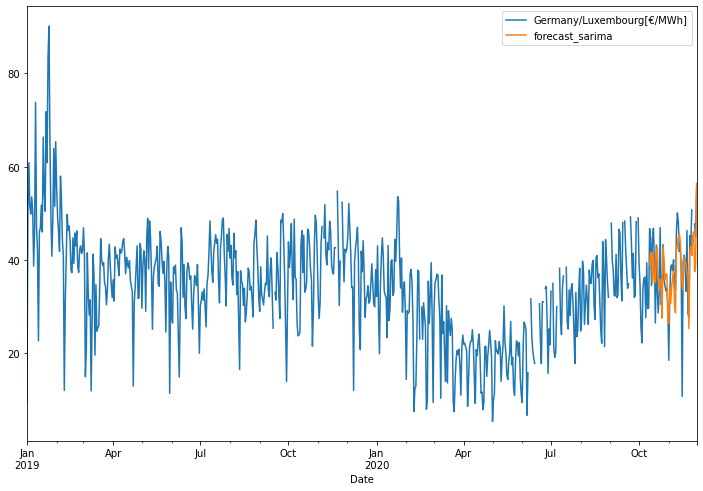

In [32]:
df_normal['forecast_sarima'] = results_sarima.predict(start = 650, end= 699)  # ,dynamic= True)  
df_normal[['Germany/Luxembourg[€/MWh]', 'forecast_sarima']].plot(figsize=(12, 8))

In [24]:
#Set index to period Day
try:
    df_normal = df_normal.asfreq('D')
    df_normal.index = pd.DatetimeIndex(df.index).to_period('D')
except:
    ar=1


    
ar = 4           # this is the maximum degree specification
#ma = (1,0,0,1)  # this is the lag polynomial specification
#ar = 0
ma = 2
order = (ar,1,ma) #1 to get the first difference

#seasonal_order = (sar,sio,sma,sp)

mod_arima = sm.tsa.statespace.SARIMAX(df_normal['Germany/Luxembourg[€/MWh]'], trend='n', order=order)
results_arima = mod_arima.fit()
results_arima.summary()

/home/cronos/.local/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
/home/cronos/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/cronos/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:     Germany/Luxembourg[€/MWh]   No. Observations:                  700
Model:                      SARIMAX(4, 1, 2)   Log Likelihood               -2326.800
Date:                       Tue, 05 Jan 2021   AIC                           4667.600
Time:                               00:11:52   BIC                           4699.448
Sample:                           01-01-2019   HQIC                          4679.912
                                - 11-30-2020                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5374      0.167      3.213      0.001       0.210       0.865
ar.L2         -0.3602      0.072     -5.016      0.000      -0.501      -0.219
ar.L3         -0.0263      0.044     -0.595      0.552      -0.113       0.060
ar.L4         -0.2094      0.047     -4.414      0.000      -0.302      -0.116
ma.L1         -1.0248      0.166     -6.177      0.000      -1.350      -0.700
ma.L2          0.2858      0.143      2.000      0.046       0.006       0.566
sigma2        57.2081      2.181     26.227      0.000      52.933      61.483
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               178.66
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Date'>

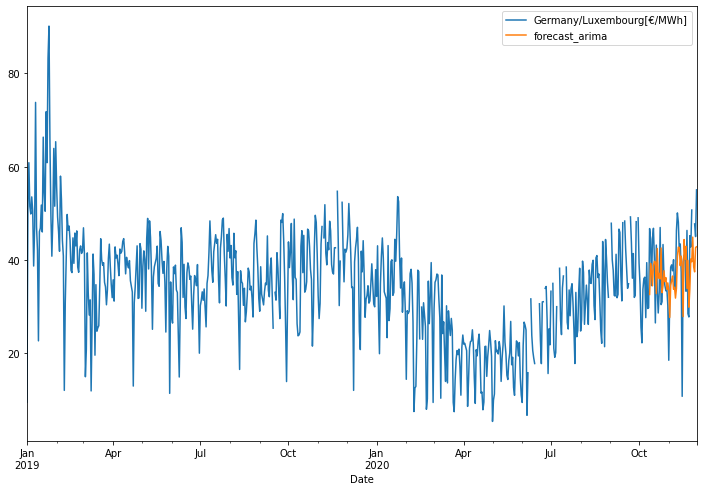

In [25]:
df_normal['forecast_arima'] = results_arima.predict(start = 650, end= 699)  # ,dynamic= True)  
df_normal[['Germany/Luxembourg[€/MWh]', 'forecast_arima']].plot(figsize=(12, 8))

In [34]:
def gridsearch_arima():
    import itertools
    #set parameter range
    p = range(0,6)
    q = range(0,6)
    d = range(0,6)
    # list of all parameter combos
    pdq = list(itertools.product(p, d, q))
    best_results = '' 
    best_aic = 100000000
    # ARIMA model pipeline
    for param in pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_normal['Germany/Luxembourg[€/MWh]'],
                                            order=param, 
                                            enforce_invertibility=False)
            results = mod.fit(max_iter = 50, method = 'powell')
            print('ARIMA{} - AIC:{}'.format(param, results.aic))
            if results.aic < best_aic:
                best_results = 'ARIMA{} - AIC:{}'.format(param,results.aic)
                best_aic = results.aic
                best_param = param
        except:
            continue

    print('Best Results: ARIMA{} - AIC:{}'.format(best_param, best_aic))
    return best_param

In [35]:
#Set index to period Day
try:
    df_normal = df_normal.asfreq('D')
    df_normal.index = pd.DatetimeIndex(df.index).to_period('D')
except:
    ar=1

order =  gridsearch_arima() #1 to get the first difference

mod_arima = sm.tsa.statespace.SARIMAX(df_normal['Germany/Luxembourg[€/MWh]'], trend='n', order=order)
results_arima = mod_arima.fit()
results_arima.summary()

/home/cronos/.local/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


Optimization terminated successfully.
         Current function value: 4.832343
         Iterations: 1
         Function evaluations: 11
ARIMA(0, 0, 0) - AIC:6767.280652130192
Optimization terminated successfully.
         Current function value: 4.345998
         Iterations: 3
         Function evaluations: 87
ARIMA(0, 0, 1) - AIC:6088.397690420357
Optimization terminated successfully.
         Current function value: 4.065917
         Iterations: 3
         Function evaluations: 108
ARIMA(0, 0, 2) - AIC:5698.284307606871
Optimization terminated successfully.
         Current function value: 3.952457
         Iterations: 4
         Function evaluations: 212
ARIMA(0, 0, 3) - AIC:5541.440368157058
Optimization terminated successfully.
         Current function value: 3.793930
         Iterations: 5
         Function evaluations: 323
ARIMA(0, 0, 4) - AIC:5321.502322687393
Optimization terminated successfully.
         Current function value: 3.701736
         Iterations: 6
         Funct

/home/cronos/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Optimization terminated successfully.
         Current function value: 3.344432
         Iterations: 2
         Function evaluations: 157
ARIMA(1, 0, 3) - AIC:4692.204122524732
Optimization terminated successfully.
         Current function value: 3.345086
         Iterations: 3
         Function evaluations: 266
ARIMA(1, 0, 4) - AIC:4695.120627535611
Optimization terminated successfully.
         Current function value: 3.343583
         Iterations: 5
         Function evaluations: 475
ARIMA(1, 0, 5) - AIC:4695.0161650875325
Optimization terminated successfully.
         Current function value: 3.459852
         Iterations: 1
         Function evaluations: 23
ARIMA(1, 1, 0) - AIC:4847.793480365552
Optimization terminated successfully.
         Current function value: 3.344904
         Iterations: 3
         Function evaluations: 123
ARIMA(1, 1, 1) - AIC:4688.865388541295
Optimization terminated successfully.
         Current function value: 3.337402
         Iterations: 2
         Fun

Optimization terminated successfully.
         Current function value: 3.443075
         Iterations: 3
         Function evaluations: 195
ARIMA(2, 2, 2) - AIC:4830.304674807561
Optimization terminated successfully.
         Current function value: 3.443581
         Iterations: 3
         Function evaluations: 245
ARIMA(2, 2, 3) - AIC:4833.013738709789
Optimization terminated successfully.
         Current function value: 3.352977
         Iterations: 7
         Function evaluations: 708
ARIMA(2, 2, 4) - AIC:4708.168136237322
Optimization terminated successfully.
         Current function value: 3.337575
         Iterations: 8
         Function evaluations: 960
ARIMA(2, 2, 5) - AIC:4688.605510131022
Optimization terminated successfully.
         Current function value: 4.004981
         Iterations: 2
         Function evaluations: 74
ARIMA(2, 3, 0) - AIC:5612.9732055141285
Optimization terminated successfully.
         Current function value: 3.669146
         Iterations: 3
         Fun

Optimization terminated successfully.
         Current function value: 3.886883
         Iterations: 3
         Function evaluations: 210
ARIMA(3, 4, 1) - AIC:5451.636153868605
Optimization terminated successfully.
         Current function value: 3.911291
         Iterations: 3
         Function evaluations: 244
ARIMA(3, 4, 2) - AIC:5487.80736210935
Optimization terminated successfully.
         Current function value: 3.642619
         Iterations: 9
         Function evaluations: 940
ARIMA(3, 4, 3) - AIC:5113.66651573038
Optimization terminated successfully.
         Current function value: 3.665227
         Iterations: 5
         Function evaluations: 654
ARIMA(3, 4, 4) - AIC:5147.318167742858
Optimization terminated successfully.
         Current function value: 3.707607
         Iterations: 5
         Function evaluations: 737
ARIMA(3, 4, 5) - AIC:5208.649600213817
Optimization terminated successfully.
         Current function value: 4.653264
         Iterations: 2
         Funct

Optimization terminated successfully.
         Current function value: 3.394954
         Iterations: 2
         Function evaluations: 141
ARIMA(5, 0, 0) - AIC:4764.935201066781
Optimization terminated successfully.
         Current function value: 3.334676
         Iterations: 6
         Function evaluations: 525
ARIMA(5, 0, 1) - AIC:4682.5467839360845
Optimization terminated successfully.
         Current function value: 3.346992
         Iterations: 4
         Function evaluations: 389
ARIMA(5, 0, 2) - AIC:4701.7893231794305
Optimization terminated successfully.
         Current function value: 3.335102
         Iterations: 6
         Function evaluations: 704
ARIMA(5, 0, 3) - AIC:4687.143194892763
Optimization terminated successfully.
         Current function value: 3.290179
         Iterations: 17
         Function evaluations: 2101
ARIMA(5, 0, 4) - AIC:4626.2502555105975
Optimization terminated successfully.
         Current function value: 3.238500
         Iterations: 15
      

/home/cronos/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:     Germany/Luxembourg[€/MWh]   No. Observations:                  700
Model:                      SARIMAX(4, 1, 5)   Log Likelihood               -2261.973
Date:                       Tue, 05 Jan 2021   AIC                           4543.945
Time:                               00:47:04   BIC                           4589.442
Sample:                           01-01-2019   HQIC                          4561.534
                                - 11-30-2020                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7684      0.015     50.773      0.000       0.739       0.798
ar.L2         -1.4227      0.013   -111.416      0.000      -1.448      -1.398
ar.L3          0.7782      0.013     59.859      0.000       0.753       0.804
ar.L4         -0.9584      0.013    -74.777      0.000      -0.984      -0.933
ma.L1         -1.3305      0.035    -37.630      0.000      -1.400      -1.261
ma.L2          1.7220      0.044     39.003      0.000       1.635       1.809
ma.L3         -1.5579      0.050    -30.866      0.000      -1.657      -1.459
ma.L4          1.2445      0.049     25.411      0.000       1.148       1.340
ma.L5         -0.5529      0.034    -16.052      0.000      -0.620      -0.485
sigma2        47.0434      1.901     24.752      0.000      43.318      50.768
===================================================================================
Ljung-Box (L1) (Q):                   2.76   Jarque-Bera (JB):               176.48
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                            -0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Date'>

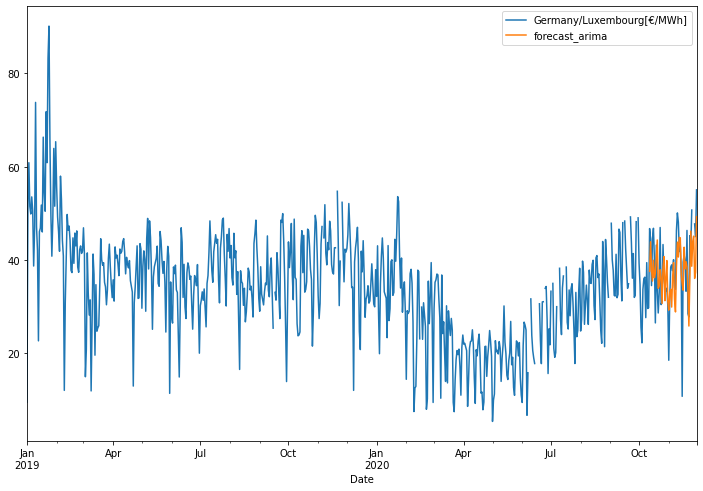

In [36]:
df_normal['forecast_arima'] = results_arima.predict(start = 650, end= 699)  # ,dynamic= True)  
df_normal[['Germany/Luxembourg[€/MWh]', 'forecast_arima']].plot(figsize=(12, 8))